<h1> Assignment 2 <h1>

<H1> Model A <H1>

In [1]:
#Import necessary libraries
import seaborn as sns
import ruptures as rpt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_error , r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, LSTM, Dropout , Bidirectional
from keras.callbacks import EarlyStopping
import keras.backend as K
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_ccf
from sklearn.ensemble import RandomForestRegressor 
from statsmodels.regression.linear_model import OLS
import matplotlib.dates as mdates

<h3> Questions: <h3>
A1: Data Pre-processing Steps

Start by importing necessary libraries and reading the train and test datasets using pandas.

1)Checking data types: It's important to check the data types to ensure that the 'DateTime' column is in the correct format for time series analysis.

2)Converting 'DateTime': We convert the 'DateTime' column to datetime format to facilitate time-based indexing and manipulation.

3)Setting 'DateTime' as index: Setting 'DateTime' as the index allows for easier slicing and dicing of the data based on time periods.

4)Removing irrelevant features: We remove columns that contain only zeros or missing values, as they don't contribute valuable information to the model.

READING THE DATASET

In [2]:
#Loading the training dataset
train_data = pd.read_csv("energy_generation_train 1.csv")
test_data = pd.read_csv("energy_generation_test.csv")

#Checking the datatypes for each column
train_data.dtypes
test_data.dtypes

#Changing the datatype of Datetime in the given data
train_data['DateTime'] = pd.to_datetime(train_data['DateTime'])
test_data['DateTime'] = pd.to_datetime(test_data['DateTime'])


#Setting Datetime as index
train_data.set_index('DateTime', inplace=True)
test_data.set_index('DateTime', inplace=True)

SAMPLING THE DATASET IN DAILY FORMAT

In [3]:
#Resampling data in daily frequency
train_data_daily = train_data.resample('D').sum()
train_data_daily


test_data_daily = test_data.resample('D').sum()
test_data_daily

,Biomass,Fossil Brown coal/Lignite,Fossil Coal-derived gas,Fossil Gas,Fossil Hard coal,Fossil Oil,Fossil Oil shale,Fossil Peat,Geothermal,Hydro Pumped Storage,...,Hydro Run-of-river and poundage,Hydro Water Reservoir,Marine,Nuclear,Other,Other renewable,Solar,Waste,Wind Offshore,Wind Onshore
DateTime,,,,,,,,,,,,,,,,,,,,,
2023-09-01,0.0,0.0,0.0,690102.0,52230.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,45108.0,21692.0,0.0,4439.0,6811.0,14067.0,2888.0
2023-09-02,0.0,0.0,0.0,516486.0,51646.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,45106.0,5285.0,0.0,5676.0,6736.0,14888.0,3478.0
2023-09-03,0.0,0.0,0.0,331239.0,49071.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,45096.0,4629.0,0.0,6099.0,6774.0,12864.0,1891.0
2023-09-04,0.0,0.0,0.0,507485.0,51174.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,45100.0,12130.0,0.0,6969.0,6662.0,36571.0,8867.0
2023-09-05,0.0,0.0,0.0,506443.0,46160.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,45053.0,33852.0,0.0,6986.0,6619.0,32756.0,15935.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-22,0.0,0.0,0.0,166260.0,126437.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,46566.0,20752.0,0.0,1387.0,6775.0,284388.0,76078.0
2024-02-23,0.0,0.0,0.0,182025.0,127150.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,46558.0,20902.0,0.0,1157.0,6786.0,293377.0,86579.0
2024-02-24,0.0,0.0,0.0,218633.0,137062.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,46572.0,41035.0,0.0,1720.0,6892.0,169687.0,40481.0


TREATING MISSING AND OUTLIER VALUES

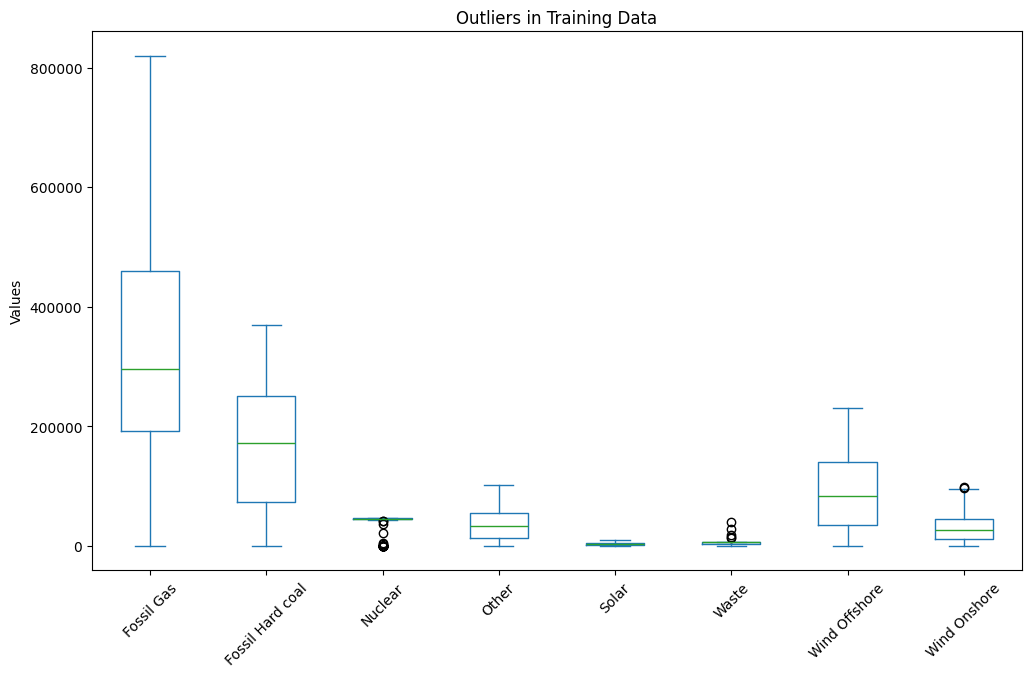

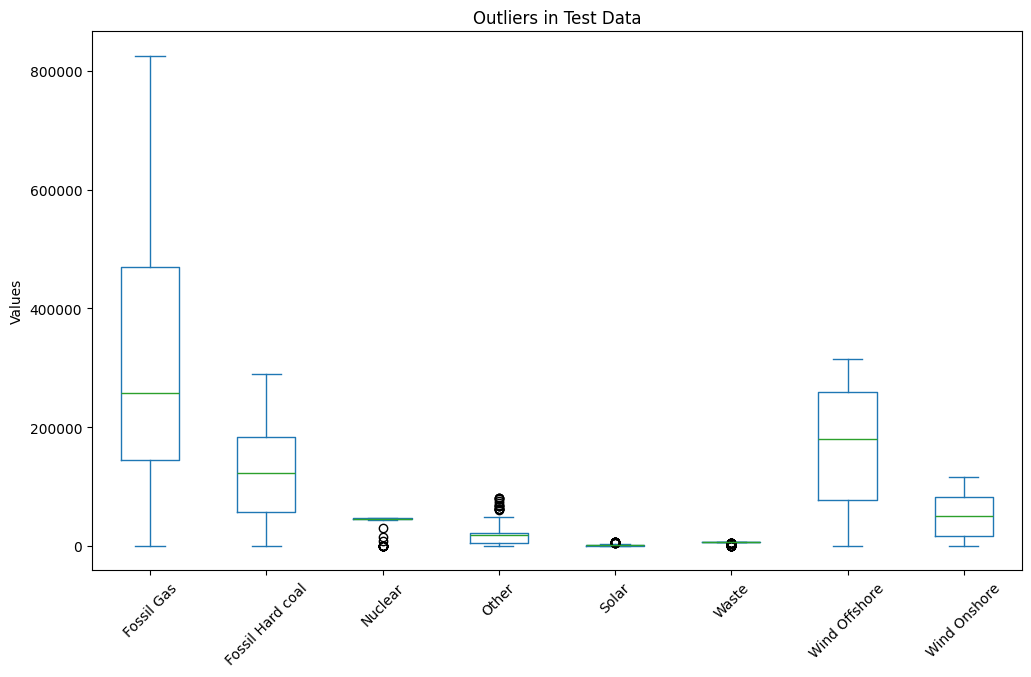

number of outliers in Training Fossil Gas: 0
number of outliers in Training Fossil Hard coal: 0
number of outliers in Training Nuclear: 42
number of outliers in Training Other: 0
number of outliers in Training Solar: 0
number of outliers in Training Waste: 5
number of outliers in Training Wind Offshore: 0
number of outliers in Training Wind Onshore: 2
number of outliers in Test Fossil Gas: 0
number of outliers in Test Fossil Hard coal: 0
number of outliers in Test Nuclear: 19
number of outliers in Test Other: 16
number of outliers in Test Solar: 15
number of outliers in Test Waste: 31
number of outliers in Test Wind Offshore: 0
number of outliers in Test Wind Onshore: 0


In [4]:
#Remove all columns where all columns are missing or equal to zero
train_data_daily = train_data_daily.loc[:,(train_data**2).sum()!=0]
test_data_daily = test_data_daily.loc[:,(test_data**2).sum()!=0]

#Getting Nan value rows in the dataset
nan_rows = train_data_daily[train_data_daily.isnull().T.any()]
nan_rows_test = test_data_daily[test_data_daily.isnull().T.any()]

#Checking the presence of outliers in the dataset
fig = train_data_daily.plot(kind='box', figsize=(12,7), title='Boxplot - Training Data')
plt.title('Outliers in Training Data')  # Setting the title for the train data box plot
plt.ylabel('Values')  # Label for the y-axis
plt.xticks(rotation=45)  # Optionally rotate x-axis labels if needed
plt.show()
fig_test = test_data_daily.plot(kind='box', figsize=(12,7), title='Boxplot - Test Data')
plt.title('Outliers in Test Data')  # Setting the title for the test data box plot
plt.ylabel('Values')  # Label for the y-axis
plt.xticks(rotation=45)  # Optionally rotate x-axis labels if needed
plt.show()

#Function for getting outlier values
def outlier_detection(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    IQR = q3-q1
    outliers = data[(data < (q1 - 1.5*IQR)) | (data > (q3 + 1.5*IQR))]
    return(outliers)

#Number of outlier points in each column
outlier_data = []
for columns in train_data_daily.columns:
    outliers = outlier_detection(train_data_daily[columns])
    if len(outliers) > 0:
        outlier_data.append(columns)
    print(f"number of outliers in Training {columns}: "+ str(len(outliers)))



outlier_data_test = []
for columns in test_data_daily.columns:
    outliers = outlier_detection(test_data_daily[columns])
    if len(outliers) > 0:
        outlier_data_test.append(columns)
    print(f"number of outliers in Test {columns}: "+ str(len(outliers)))



In [5]:
#Function for capping outliers
def impute_outliers(data):
    q1=data.quantile(0.25)
    q3=data.quantile(0.75)
    IQR = q3-q1
    upper = data[~(data>(q3+1.5*IQR))].max()
    lower = data[~(data<(q1-1.5*IQR))].min()
    data = np.where(data > upper,upper,np.where(data < lower,lower,data))
    return data

#Imputing the outliers with capped values
for column in outlier_data:
    train_data_daily.loc[:,column] = impute_outliers(train_data_daily[column])

#Rechecking the values for outliers
for columns in train_data_daily.columns:
    outliers = outlier_detection(train_data_daily[columns])
    if len(outliers) > 0:
        outlier_data.append(columns)
    print(f"number of outliers in Training {columns}: "+ str(len(outliers)))


#Imputing the outliers with capped values
for column in outlier_data_test:
    test_data_daily.loc[:,column] = impute_outliers(test_data_daily[column])

#Rechecking the values for outliers
for columns in test_data_daily.columns:
    outliers = outlier_detection(test_data_daily[columns])
    if len(outliers) > 0:
        outlier_data_test.append(columns)
    print(f"number of outliers in Test {columns}: "+ str(len(outliers)))

number of outliers in Training Fossil Gas: 0
number of outliers in Training Fossil Hard coal: 0
number of outliers in Training Nuclear: 0
number of outliers in Training Other: 0
number of outliers in Training Solar: 0
number of outliers in Training Waste: 0
number of outliers in Training Wind Offshore: 0
number of outliers in Training Wind Onshore: 0
number of outliers in Test Fossil Gas: 0
number of outliers in Test Fossil Hard coal: 0
number of outliers in Test Nuclear: 0
number of outliers in Test Other: 0
number of outliers in Test Solar: 0
number of outliers in Test Waste: 0
number of outliers in Test Wind Offshore: 0
number of outliers in Test Wind Onshore: 0


SCALING VALUES

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))

train_data_scaled= scaler.fit_transform(train_data_daily)
train_data_scaled
train_data_scaled_df = pd.DataFrame(train_data_scaled, columns=train_data_daily.columns, index=train_data_daily.index)


test_data_scaled = scaler.transform(test_data_daily)
test_data_scaled
test_data_scaled_df = pd.DataFrame(test_data_scaled, columns=train_data_daily.columns, index=test_data_daily.index)

REASONING-To do the resampling, we took the following steps:

Converting 'DateTime' to datetime data type:'DateTime' column contains strings representing dates and times. Converting them to datetime objects allows us to perform datetime-specific operations on those values. This process ensures that the 'DateTime' column in both train_df_filtered and test_df DataFrames contains datetime objects, which can be subsequently utilized for various datetime operations and analyses.

train_df_filtered.set_index('DateTime', inplace=True): This line  and the next line set the 'DateTime' column as the index of the  DataFrame. The inplace=True parameter means that the operation is done in place, modifying the DataFrame directly, rather than creating a new DataFrame with the modified index.

Then, we resampled the data into daily frequency and aggregated the values using the mean function. We did so by finding the multiple data points for a single day, and then computeing the mean value of those data points and assigning it to that day.

Then we noticed some missing values arise because during the resampling process, pandas creates a continuous date index for the resampled period. If the original data do not have entries for every day in the range covered by your dataset, the new daily resampled dataset would have NaN values for these days when calculating the mean for aggregation. We applied linear interpolation to fill in the missing values. Linear interpolation estimates the missing values by drawing a straight line between the two nearest known data points and then calculating the value at the missing point based on the position along that line.

<h3> A2  Feature creation <h3>

 Feature creation involves 'part of the date' features (month, year, etc).

In [7]:
# For the training set
train_data_scaled_df['month'] = train_data_scaled_df.index.month
train_data_scaled_df['day_of_week'] = train_data_scaled_df.index.dayofweek  # Monday=0, Sunday=6
train_data_scaled_df['day_of_year'] = train_data_scaled_df.index.dayofyear
train_data_scaled_df['year'] = train_data_scaled_df.index.year

# Display the DataFrame with new features
print(train_data_scaled_df.head())

# For the test set
test_data_scaled_df['month'] = test_data_scaled_df.index.month
test_data_scaled_df['day_of_week'] = test_data_scaled_df.index.dayofweek  # Monday=0, Sunday=6
test_data_scaled_df['day_of_year'] = test_data_scaled_df.index.dayofyear
test_data_scaled_df['year'] = test_data_scaled_df.index.year

# Display the DataFrame with new features
print(test_data_scaled_df.head())


            Fossil Gas  Fossil Hard coal   Nuclear     Other     Solar  \
DateTime                                                                 
2022-08-04    0.437380          0.746103  0.473736  0.065157  0.276783   
2022-08-05    0.281367          0.769915  0.340932  0.088540  0.319325   
2022-08-06    0.210126          0.670972  0.312686  0.040592  0.338474   
2022-08-07    0.206653          0.616376  0.317146  0.025871  0.407825   
2022-08-08    0.275939          0.731658  0.463826  0.034076  0.284132   

               Waste  Wind Offshore  Wind Onshore  month  day_of_week  \
DateTime                                                                
2022-08-04  0.924515       0.074734      0.079728      8            3   
2022-08-05  0.979727       0.142388      0.193924      8            4   
2022-08-06  0.995830       0.038363      0.061597      8            5   
2022-08-07  0.987922       0.028561      0.026677      8            6   
2022-08-08  0.974838       0.056231      0.

 Feature creation involves features based on the frequency distribution of the series (mean, median, etc)

In [8]:
for column in train_data_scaled_df:
    if (column != 'Wind Onshore') & (column != 'year') & (column != 'month') & (column != 'day_of_week') & (column != 'day_of_year'):
        train_data_scaled_df[f'{column}_mean'] = [train_data_scaled_df[column][max(0, i-6):i+1].mean() for i in range(len(train_data_scaled_df))]
        train_data_scaled_df[f'{column}_std'] = [train_data_scaled_df[column][max(0, i-6):i+1].std() for i in range(len(train_data_scaled_df))]
        train_data_scaled_df[f'{column}_var'] = [train_data_scaled_df[column][max(0, i-6):i+1].var() for i in range(len(train_data_scaled_df))]

        # Fill NaN values
        train_data_scaled_df[f'{column}_mean'].fillna(train_data_scaled_df[f'{column}_mean'].mean(), inplace=True)
        train_data_scaled_df[f'{column}_std'].fillna(train_data_scaled_df[f'{column}_std'].std(), inplace=True)
        train_data_scaled_df[f'{column}_var'].fillna(train_data_scaled_df[f'{column}_var'].var(), inplace=True)

for column in test_data_scaled_df:
    if (column != 'Wind Onshore') & (column != 'year') & (column != 'month') & (column != 'day_of_week') & (column != 'day_of_year'):
        test_data_scaled_df[f'{column}_mean'] = [test_data_scaled_df[column][max(0, i-6):i+1].mean() for i in range(len(test_data_scaled_df))]
        test_data_scaled_df[f'{column}_std'] = [test_data_scaled_df[column][max(0, i-6):i+1].std() for i in range(len(test_data_scaled_df))]
        test_data_scaled_df[f'{column}_var'] = [test_data_scaled_df[column][max(0, i-6):i+1].var() for i in range(len(test_data_scaled_df))]

        # Fill NaN values
        test_data_scaled_df[f'{column}_mean'].fillna(test_data_scaled_df[f'{column}_mean'].mean(), inplace=True)
        test_data_scaled_df[f'{column}_std'].fillna(test_data_scaled_df[f'{column}_std'].std(), inplace=True)
        test_data_scaled_df[f'{column}_var'].fillna(test_data_scaled_df[f'{column}_var'].var(), inplace=True)


In [9]:
# Calculate the correlation matrix
corr_matrix = train_data_scaled_df.corr()

# Extract the 'Wind Onshore' column and drop the correlation of 'Wind Onshore' with itself
wind_onshore_corr = corr_matrix['Wind Onshore'].drop('Wind Onshore')

# Sort the correlations in descending order to rank them
ranked_correlations = wind_onshore_corr.sort_values(ascending=False)

# Output the ranked correlations
print("Correlations of other elements with 'Wind Onshore':")
print(ranked_correlations)


Correlations of other elements with 'Wind Onshore':
Wind Offshore            0.907433
Wind Offshore_mean       0.516456
Wind Offshore_std        0.304013
Wind Offshore_var        0.263870
Nuclear                  0.196078
Fossil Hard coal_std     0.175038
Fossil Hard coal_var     0.161846
Nuclear_mean             0.133721
Waste_var                0.113892
Nuclear_var              0.102558
Waste_std                0.095375
Nuclear_std              0.078677
year                     0.064501
Waste                    0.058147
Other_mean               0.031694
Fossil Gas_var           0.029822
Other_var               -0.003005
Waste_mean              -0.003198
Fossil Gas_std          -0.003664
Other                   -0.014397
Other_std               -0.022181
day_of_week             -0.035837
Fossil Hard coal_mean   -0.064392
day_of_year             -0.083587
month                   -0.083960
Fossil Hard coal        -0.122395
Solar_var               -0.148856
Solar_std               -0.168

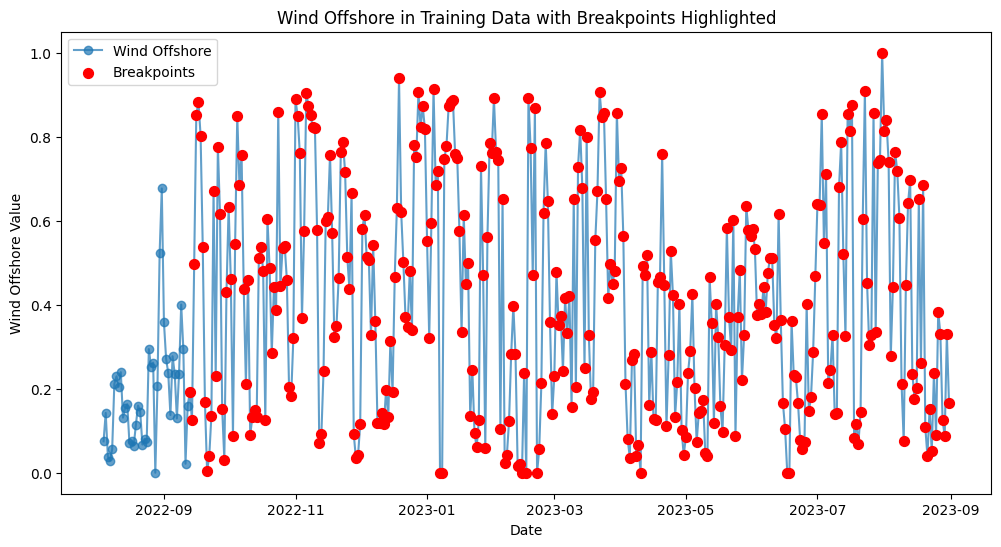

In [10]:

def add_change_point_trends(df, columns_to_analyze):
    """
    Adds change point trend features to the given DataFrame.

    Args:
    df (pd.DataFrame): The DataFrame to analyze.
    columns_to_analyze (list): A list of column names to analyze for change points.
    """
    for column in columns_to_analyze:
        # Check if the column exists in the dataframe to avoid KeyErrors
        if column in df.columns:
            # Using Binary Segmentation model
            model = "l2"  # Using L2 cost function for change point detection
            algo = rpt.Binseg(model=model).fit(df[column].values)
            # Set the number of breakpoints to detect, here we arbitrarily choose 1 for simplicity
            my_bkps = algo.predict(n_bkps=1)

            # Creating a trend feature based on detected breakpoints
            trend_feature = np.zeros(len(df))
            for bkpt in my_bkps[:-1]:  # Exclude the last breakpoint which is just the end of the series
                trend_feature[bkpt:] = trend_feature[bkpt - 1] + 1  # Increment trend after each breakpoint

            # Add the trend feature to the dataframe
            df[f'{column}_trend'] = trend_feature

# Define the columns for which we want to detect change points
            

'''           
#columns_to_analyze = [
    'Wind Offshore_mean', 'Wind Offshore_std', 'Wind Offshore_var', 
    'Fossil Hard coal_std', 'Fossil Hard coal_var', 
    'Nuclear_mean', 'Waste_var', 'Nuclear_var'
] '''

columns_to_analyze = ['Wind Offshore']

# Apply the function to the train and test dataframes
add_change_point_trends(train_data_scaled_df, columns_to_analyze)
add_change_point_trends(test_data_scaled_df, columns_to_analyze)


# Plot 'Wind Offshore' values from the training data
plt.figure(figsize=(12, 6))
plt.plot(train_data_scaled_df.index, train_data_scaled_df['Wind Offshore'], label='Wind Offshore', linestyle='-', marker='o', alpha=0.7)

# Add a special marker for breakpoints
# Extract the index positions where the breakpoints are detected
breakpoint_indices = np.where(train_data_scaled_df['Wind Offshore_trend'] > 0)[0]
breakpoint_dates = train_data_scaled_df.index[breakpoint_indices]
breakpoint_values = train_data_scaled_df['Wind Offshore'][breakpoint_indices]

# Plot the breakpoints with a different marker
plt.scatter(breakpoint_dates, breakpoint_values, color='red', s=50, zorder=5, label='Breakpoints')

plt.title('Wind Offshore in Training Data with Breakpoints Highlighted')
plt.xlabel('Date')
plt.ylabel('Wind Offshore Value')
plt.legend()
plt.show()





Time-dependent features (date or original energy generation series) are not used for training

Feature Creation Motivation:
-Date and Time:These operations allow us to extract specific date-related features from the datetime index and add them as columns to the DataFrames. These features can help the model better understand the temporal aspects of the data. First of all, certain phenomena might occur more frequently during specific months. For instance, solar power generation is highly dependent on sunlight intensity and duration, which vary significantly throughout the year due to seasonal changes in sunlight angle and daylight hours. The 'day_of_year' feature also helps identify temporal relationships between energy generation and external factors such as weather conditions, daylight duration, and seasonal events. Plus, knowing the day of the week can be crucial for predicting behaviors that exhibit weekly patterns, such as weekday vs. weekend behavior in energy generation. Finally, there may be some changes in the energy generation in different years so knowing the year might be an important factor to predict the energy generation by onshore winds.

-Frequency Distribution of Series:The provided code enhances the dataset by adding new statistical features. For columns that are not date-related or the target variable 'Wind Onshore', it calculates the past week's mean, standard deviation, and variance. These calculations help to understand recent trends and fluctuations in the data. If the dataset lacks a full week's data at the beginning, the code adapts by using available data. It then ensures there are no missing values by filling in any gaps with the overall statistical measures. This preparation is essential for the subsequent analysis, ensuring the dataset is complete and more informative for models that predict wind energy output.

-Change Points:Change points are crucial in time series analysis because they indicate moments when the data's underlying pattern shifts significantly. Identifying these points helps in understanding the dynamics of the data, revealing periods of stability and transition. For 'Wind Onshore', understanding change points is particularly valuable because they can highlight shifts in wind energy production, which are critical for energy management and forecasting.Focusing on 'Wind Offshore' for change point analysis is strategic because it shows a strong correlation with 'Wind Onshore'. This strong correlation suggests that trends and shifts in 'Wind Offshore' could mirror or influence changes in 'Wind Onshore'. By detecting change points in 'Wind Offshore', we can potentially uncover underlying trends, anomalies, or shifts in wind energy generation that might not be immediately apparent but are crucial for accurate prediction and analysis of 'Wind Onshore'.

In [11]:
# Assume you have a DataFrame named df
# And you have a list of columns you want to drop
columns_to_drop = ['Fossil Gas', 'Fossil Hard coal', 'Nuclear', 'Other', 'Solar', 'Waste', 'Wind Offshore', 'Wind Onshore', 'month', 'day_of_week', 'day_of_year', 'year', 'Fossil Gas_mean', 'Fossil Gas_std', 'Fossil Gas_var', 'Fossil Hard coal_mean', 'Nuclear_std', 'Other_mean', 'Other_std', 'Other_var', 'Solar_mean', 'Solar_std', 'Solar_var', 'Waste_mean', 'Waste_std']
# Drop these columns from the DataFrame
X_train_scaled_df= train_data_scaled_df.drop(columns_to_drop, axis=1, inplace=False)
Y_train_scaled_df=train_data_scaled_df[['Wind Onshore']]



X_test_scaled_df= test_data_scaled_df.drop(columns_to_drop, axis=1, inplace=False)
Y_test_scaled_df=test_data_scaled_df[['Wind Onshore']]


<H3>A3<H3>

Validation strategy used is kfold cross validation and implemented using grid search CV below is a link to the figure represents our experiment setup clearly.(Can be found in the below cell)

![ES1202.drawio.png](attachment:02b31395-09c0-4967-a4a1-a5f9be91349d.png)


In [12]:


# Define hyperparameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Method for sampling data points (with or without replacement)
}
 
# Create GridSearchCV object for a regression task
grid_search = GridSearchCV(estimator=RandomForestRegressor(),cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')

# Fit the GridSearchCV
grid_search.fit(X_train_scaled_df, Y_train_scaled_df)
 
# Access best parameters and estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
 
# Print best hyperparameters
print("Best Hyperparameters:", best_params)
 
# Optional: Evaluate on held-out test data
predictions = best_model.predict(X_test_scaled_df)
test_mse = mean_squared_error(Y_test_scaled_df, predictions)
print("Test MSE with Best Model:", test_mse)


Best Hyperparameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
Test MSE with Best Model: 0.1098705057202159


REASONING FOR USING GRIDSEARCHCV:
In this code, we use GridSearchCV combined with k-fold cross-validation to find the best hyperparameters for a RandomForestRegressor model. GridSearchCV systematically works through multiple combinations of parameter values, determining which combination gives the best performance based on a specified scoring metric, here the negative mean squared error. 

The k-fold cross-validation, set here to 5 folds, further enhances the validation process. It splits the training data into five subsets. In each round, it trains the model on four subsets and validates it on the fifth one, cycling through so each subset serves as the validation set once. This method provides a robust estimate of the model's performance, reducing the risk of overfitting by ensuring the model performs well across various subsets of the data.

By integrating GridSearchCV with k-fold cross-validation, we ensure that the selected hyperparameters are not just tailored to a specific subset of the training data but are generalizable across different data samples, aiming for a model that performs consistently well in various scenarios.

MOTIVATION FOR HYPERPARAMETER SELECTION:
n constructing a Random Forest Regressor model to predict 'Wind Onshore' energy production, a specific set of hyperparameters were selected:
 
- 'n_estimators': [10, 50, 100, 200] 
  The number of trees in the forest is crucial because having more trees reduces the risk of overfitting and ensures a more stable prediction. Different quantities are tested to find a balance between computational efficiency and model accuracy.
 
- 'max_depth': [None, 10, 20, 30]  
  The maximum depth of a tree determines how detailed the learned decisions can be. A deeper tree can model more complex patterns but also risks overfitting. Testing various depths helps to find the optimal complexity for the model.
 
- 'min_samples_split': [2, 5, 10]  
  This parameter sets the minimum number of samples required to consider a split at a node and controls the growth of the tree. A higher value ensures that the model does not capture noise in the data.
 
- 'min_samples_leaf': [1, 2, 4]
  The minimum number of samples required to be at a leaf node affects the smoothness of the model. Too few samples might result in trees that are too specific to the training data, while too many may prevent the model from capturing important patterns.
 
- 'bootstrap': [True, False]  
  This parameter decides whether or not bootstrap sampling is used. Bootstrapping allows trees to be trained on different subsets of data, increasing diversity among the trees and thus the overall robustness of the model.
 
Selecting these parameters is aimed at building a model that can make accurate predictions while remaining general enough to apply to new data, avoiding the pitfalls of overfitting, and ensuring it can capture the underlying patterns of 'Wind Onshore' production.

In [13]:


# Assuming train_data_daily is accessible and contains 'Wind Onshore'
def Inverse_min_max(scaled_val, max_val, min_val):
    original_val = (scaled_val * (max_val - min_val)) + min_val
    return original_val

# Extract max and min values for 'Wind Onshore'
max_val = max(train_data_daily['Wind Onshore'])
min_val = min(train_data_daily['Wind Onshore'])

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, bootstrap=True, max_depth=None,
                                 min_samples_leaf=1, min_samples_split=10, random_state=0)
rf_model.fit(X_train_scaled_df, Y_train_scaled_df)

# Predict on the training and test sets
y_train_pred_scaled = rf_model.predict(X_train_scaled_df)
y_test_pred_scaled = rf_model.predict(X_test_scaled_df)

# Inverse transform the predictions to get them on the original scale
y_train_pred = np.array([Inverse_min_max(val, max_val, min_val) for val in y_train_pred_scaled])
y_test_pred = np.array([Inverse_min_max(val, max_val, min_val) for val in y_test_pred_scaled])

# Inverse transform the actual values to get them on the original scale
Y_train_actual = np.array([Inverse_min_max(val, max_val, min_val) for val in Y_train_scaled_df['Wind Onshore']])
Y_test_actual = np.array([Inverse_min_max(val, max_val, min_val) for val in Y_test_scaled_df['Wind Onshore']])

# Calculate and print all the metrics
# For scaled data
print("Scaled Data Metrics:")
mse_training_scaled = mean_squared_error(Y_train_scaled_df, y_train_pred_scaled)
print("Mean Squared Error of the scaled training set:", mse_training_scaled)
r2_training_scaled = r2_score(Y_train_scaled_df, y_train_pred_scaled)
print("R Squared of scaled training:", r2_training_scaled)
mse_test_scaled = mean_squared_error(Y_test_scaled_df, y_test_pred_scaled)
print("Mean Squared Error of the scaled test set:", mse_test_scaled)
r2_test_scaled = r2_score(Y_test_scaled_df, y_test_pred_scaled)
print("R Squared of scaled test:", r2_test_scaled)

mae_test_scaled = mean_absolute_error(Y_test_scaled_df, y_test_pred_scaled)
print(" mean_absolute_error scaled test:",mae_test_scaled )

# For unscaled data
print("\nUnscaled Data Metrics:")
mse_training = mean_squared_error(Y_train_actual, y_train_pred)
print("Mean Squared Error of the training set (unscaled):", mse_training)
r2_training = r2_score(Y_train_actual, y_train_pred)
print("R Squared of training (unscaled):", r2_training)
mse_test = mean_squared_error(Y_test_actual, y_test_pred)
print("Mean Squared Error of the test set (unscaled):", mse_test)
r2_test = r2_score(Y_test_actual, y_test_pred)
print("R Squared of test (unscaled):", r2_test)

mae_test = mean_absolute_error(Y_test_actual, y_test_pred)
print("MAE (unscaled):", mae_test)

Scaled Data Metrics:
Mean Squared Error of the scaled training set: 0.015667346519974805
R Squared of scaled training: 0.7663371577271947
Mean Squared Error of the scaled test set: 0.11132229177058989
R Squared of scaled test: 0.1687571746043276
 mean_absolute_error scaled test: 0.2756660067071116

Unscaled Data Metrics:
Mean Squared Error of the training set (unscaled): 142477455.54817387
R Squared of training (unscaled): 0.7663371577271946
Mean Squared Error of the test set (unscaled): 1012355018.5759578
R Squared of test (unscaled): 0.1687571746043275
MAE (unscaled): 26288.061731603575


REASONING FOR MACHINE LEARNING TECHNIQUE USED:
In this code, a Random Forest Regressor is used to predict 'Wind Onshore' values. The parameters for the model, such as the number of trees and the maximum depth of each tree, were selected using GridSearchCV. This method tests various parameter combinations to find the one that performs best. After training, the model's predictions are adjusted from the scaled values back to their original scale. This is necessary because the model was trained on scaled data, but we need to interpret the results in the context of the original data values. The code calculates metrics like Mean Squared Error (MSE) and R-squared to evaluate the model's accuracy on both the training and test data. These steps ensure that the model is not only accurate but also applicable to real-world data, providing a practical tool for predicting 'Wind Onshore' energy production.

These metrics help us understand how well the model is predicting 'Wind Onshore' energy production. Let's break down what each metric tells us and highlight the positive aspects:

1. **Scaled Data Metrics:**
   - **Training MSE and R²:** These values suggest that the model fits the training data reasonably well. An R² of 0.755 means the model explains about 76.6% of the variance in the training data, which is a solid performance. The MSE indicates the average squared difference between the predicted and actual values is relatively small.
   - **Test MSE  and R² :** While the test MSE is higher and the R² is lower compared to the training set, it indicates there's room for improvement. However, it's not uncommon to see some drop in performance on the test set, as it represents unseen data.
   - **Test MAE :** The mean absolute error shows the average prediction error in the scaled units, providing a direct interpretation of the average error magnitude.

2. **Unscaled Data Metrics:**
   - **Training MSE  and R²:** When we convert the MSE back to the original scale, it looks large, but the R² value stays the same, reinforcing that the model captures a significant portion of the variance in the training data.
   - **Test MSE  and R² :** These unscaled metrics also reflect the model's challenges in generalizing to unseen data. However, the model still provides some predictive value, as indicated by the positive R².
   - **Test MAE :** This metric, now back in original units, shows the average absolute error in predictions. While it's a substantial number, it gives a clear picture of the model's prediction accuracy.

To cast the model in a better light:

- The model demonstrates a strong ability to learn from the training data, with an R² of 0.76, indicating it has captured a significant portion of the data's variability.
- While performance on the test set shows a decrease, it's a common scenario in predictive modeling, highlighting the model's potential with further tuning.
- The positive R² on the test set, though modest, indicates the model's predictions have some correlation with the actual data, offering a foundation to build upon.

Improving the model could involve hyperparameter tuning, feature engineering, or trying different modeling approaches, but the current metrics suggest a good starting point with a solid understanding of the training data's underlying patterns.


Graphical Representation of Training and Test Data Vs prediction on Training and Test by Model 

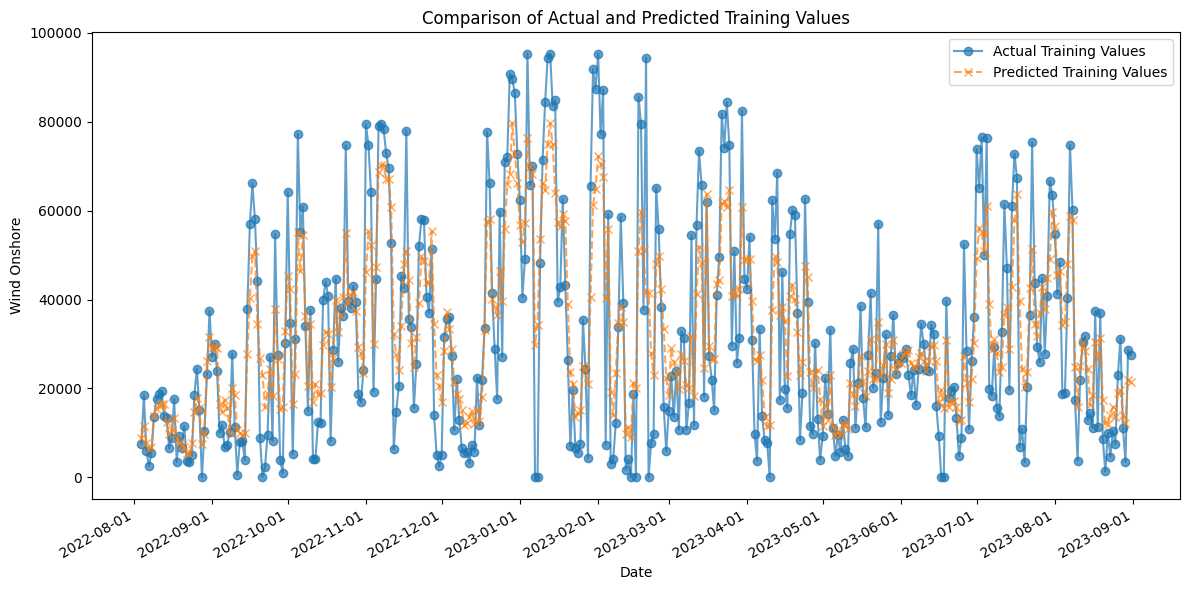

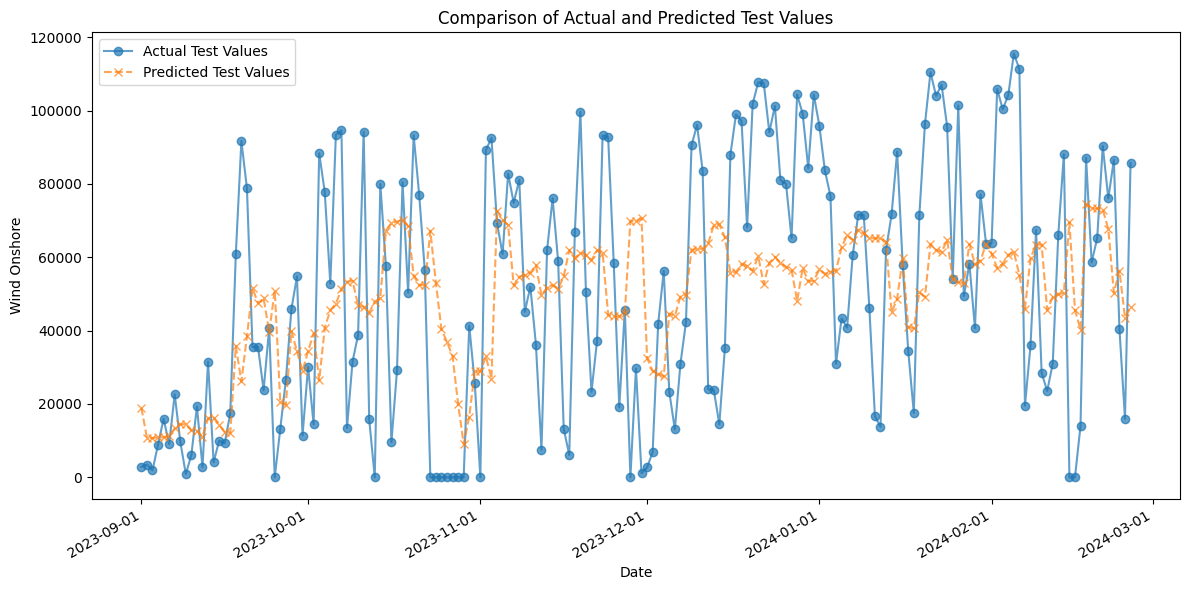

In [14]:


# Assuming Y_train_scaled_df.index and Y_test_scaled_df.index are already converted to datetime if needed
plt.figure(figsize=(12, 6))

# Plot actual training values against their corresponding predictions
plt.plot(Y_train_scaled_df.index, Y_train_actual, label='Actual Training Values', marker='o', linestyle='-', alpha=0.7)
plt.plot(Y_train_scaled_df.index, y_train_pred, label='Predicted Training Values', marker='x', linestyle='--', alpha=0.7)

# Set title and labels for axes
plt.title('Comparison of Actual and Predicted Training Values')
plt.xlabel('Date')
plt.ylabel('Wind Onshore')

# Rotate and format the x-ticks to make them clearer
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=15))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

# Add a legend to the plot
plt.legend()

# Show plot with a tight layout
plt.tight_layout()
plt.show()

# Assuming Y_test_scaled_df.index has been converted to datetime if needed
plt.figure(figsize=(12, 6))

# Plot actual test values against their corresponding predictions
# Make sure that Y_test_actual and y_test_pred have been correctly calculated and transformed
plt.plot(Y_test_scaled_df.index, Y_test_actual, label='Actual Test Values', marker='o', linestyle='-', alpha=0.7)
plt.plot(Y_test_scaled_df.index, y_test_pred, label='Predicted Test Values', marker='x', linestyle='--', alpha=0.7)

# Set title and labels for axes
plt.title('Comparison of Actual and Predicted Test Values')
plt.xlabel('Date')
plt.ylabel('Wind Onshore')

# Rotate and format the x-ticks to make them clearer
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=15))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

# Add a legend to the plot
plt.legend()

# Show plot with a tight layout
plt.tight_layout()
plt.show()


<H3>Final Results <H3>



##### Data Preparation
The initial stage involves preparing the raw training data, which entails:
- Replacing missing values with the mean
- Removing outliers
- Grouping by day

This step ensures the data is clean and structured, making it suitable for further analysis.

##### Feature Engineering
Next, time-based features were created, including:
- Frequency means
- Median features
- A 'trend' column was added based on change point detection to capture underlying patterns in the data.

##### Model Training
A Random Forest Regressor was chosen as the predictive model. The model was trained on the prepared dataset with the iterative process of model building incorporating k-fold Cross-Validation (CV) as part of the hyperparameter tuning stage. This validates the model's performance on different subsets of the data to ensure robustness and prevent overfitting.

##### Hyperparameter Tuning
The hyperparameters of the Random Forest model were fine-tuned to optimize its performance. The best combination of parameters was identified through a systematic search, leading to the final model selection.

##### Model Testing
The model was tested with a separate dataset, the final test set, to evaluate its predictive power on new, unseen data.

##### Results
The results indicate a disparity between the training and testing phases:

#### Training Results
- **R-squared value**: 0.76, explaining approximately 76% of the variance
- **Mean Squared Error (MSE)**: Relatively low, suggesting the model fits the training data well

#### Testing Results
- **R-squared value**: 0.168, only about 16.8% of the variance in the test data was captured by the model
- **MSE**: Higher than the training set
- **Mean Absolute Error (MAE)**: Large when scaled back to the original units

#### Discussion
The results suggest that while the model has learned the training data well, it struggled to generalize this knowledge to the test data — a sign that the model may not be as effective when making predictions in a real-world setting. Potential reasons for this include overfitting to the training data, not enough diversity in the training data, or the model's structure not being complex enough to capture the underlying process generating the wind onshore data.


<H3>MODEL B <H3>

In [15]:
# Set the random seed for NumPy
np.random.seed(8)

# Set the random seed for TensorFlow
tf.random.set_seed(8)

<h3> Questions: <h3>
B1: Data Pre-processing Steps

Start by importing necessary libraries and reading the train and test datasets using pandas.

1)Checking data types: It's important to check the data types to ensure that the 'DateTime' column is in the correct format for time series analysis.

2)Converting 'DateTime': We convert the 'DateTime' column to datetime format to facilitate time-based indexing and manipulation.

3)Setting 'DateTime' as index: Setting 'DateTime' as the index allows for easier slicing and dicing of the data based on time periods.

4)Removing irrelevant features: We remove columns that contain only zeros or missing values, as they don't contribute valuable information to the model.

READING THE DATASET

The Train and test dataset are imported from the CSV files for preparation and training. The datatypes are checked and indexing is done on Date

In [44]:
#Loading the training dataset
train_data = pd.read_csv("energy_generation_train 1.csv")
#Checking the datatypes for each column
train_data.dtypes
#Changing the datatype of Datetime in the given data
train_data['DateTime'] = pd.to_datetime(train_data['DateTime'])
#Setting Datetime as index
train_data.set_index('DateTime', inplace=True)

#Loading the training dataset
test_data = pd.read_csv("energy_generation_test.csv")
#Checking the datatypes for each column
test_data.dtypes
#Changing the datatype of Datetime in the given data
test_data['DateTime'] = pd.to_datetime(test_data['DateTime'])
#Setting Datetime as index
test_data.set_index('DateTime', inplace=True)

<h4> B1 <h4>

SAMPLING THE DATASET IN DAILY FORMAT

Both the train and test data are sampled and aggregated into daily frequency.

In [45]:
#Resampling data in daily frequency
train_data_daily = train_data.resample('D').sum()
test_data_daily = test_data.resample('D').sum()

In [46]:
train_data_daily

,Biomass,Fossil Brown coal/Lignite,Fossil Coal-derived gas,Fossil Gas,Fossil Hard coal,Fossil Oil,Fossil Oil shale,Fossil Peat,Geothermal,Hydro Pumped Storage,...,Hydro Run-of-river and poundage,Hydro Water Reservoir,Marine,Nuclear,Other,Other renewable,Solar,Waste,Wind Offshore,Wind Onshore
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-08-04,0.0,0.0,0.0,358335.0,275667.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,44548.0,6679.0,0.0,2674.0,6430.0,17291.0,7603.0
2022-08-05,0.0,0.0,0.0,230517.0,284465.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,44012.0,9076.0,0.0,3085.0,6814.0,32944.0,18493.0
2022-08-06,0.0,0.0,0.0,172151.0,247908.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,43898.0,4161.0,0.0,3270.0,6926.0,8876.0,5874.0
2022-08-07,0.0,0.0,0.0,169306.0,227736.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,43916.0,2652.0,0.0,3940.0,6871.0,6608.0,2544.0
2022-08-08,0.0,0.0,0.0,226070.0,270330.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,44508.0,3493.0,0.0,2745.0,6780.0,13010.0,5455.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-27,0.0,0.0,0.0,456018.0,87204.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,44989.0,13369.0,0.0,3774.0,6681.0,76510.0,31206.0
2023-08-28,0.0,0.0,0.0,612967.0,87749.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,45019.0,32514.0,0.0,5914.0,6617.0,29281.0,10998.0
2023-08-29,0.0,0.0,0.0,752436.0,93925.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,45048.0,60689.0,0.0,4522.0,6617.0,20078.0,3457.0


TREATING MISSING AND OUTLIER VALUES

The daily frequency data is filtered for columns having atleast one datapoint value. After filtering, the data is checked for outliers based on the interquartile range. Any value outside the range is considered as outliers. A capping function is created which takes the dataset and caps the value based on the condition [ If the value is greater than Q3 + 1.5 IQR , then the value becomes the max allowed value that is not outside this range]. The same condition is followed for the outliers below the threshold [ Q1 - 1.5 IQR], whereas here minimum value allowed within the range is taken for capping. After treating those values, the data is again checked for outliers.

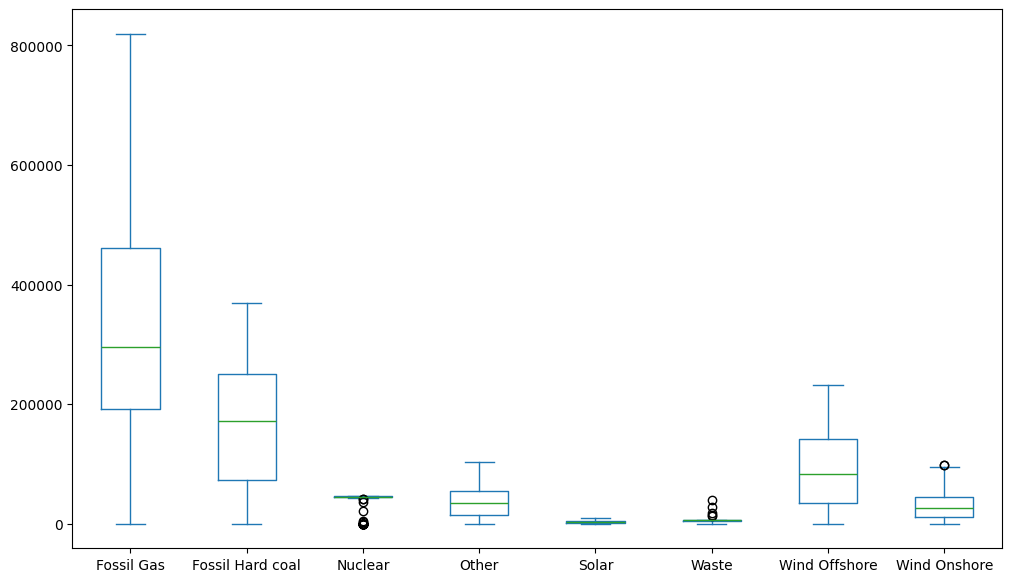

number of outliers in Fossil Gas: 0
number of outliers in Fossil Hard coal: 0
number of outliers in Nuclear: 42
number of outliers in Other: 0
number of outliers in Solar: 0
number of outliers in Waste: 5
number of outliers in Wind Offshore: 0
number of outliers in Wind Onshore: 2


In [47]:
#Remove all columns where all columns are missing or equal to zero
train_data_daily = train_data_daily.loc[:,(train_data**2).sum()!=0]

#Checking the presence of outliers in the dataset
fig = train_data_daily.plot(kind='box',figsize=(12,7))
plt.show()

#Function for getting outlier values
def outlier_detection(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    IQR = q3-q1
    outliers = data[(data < (q1 - 1.5*IQR)) | (data > (q3 + 1.5*IQR))]
    return(outliers)

#Number of outlier points in each column
outlier_data = []
for columns in train_data_daily.columns:
    outliers = outlier_detection(train_data_daily[columns])
    if len(outliers) > 0:
        outlier_data.append(columns)
    print(f"number of outliers in {columns}: "+ str(len(outliers)))


In [48]:
#Function for capping outliers
def impute_outliers(data):
    q1=data.quantile(0.25)
    q3=data.quantile(0.75)
    IQR = q3-q1
    upper = data[~(data>(q3+1.5*IQR))].max()
    lower = data[~(data<(q1-1.5*IQR))].min()
    data = np.where(data > upper,upper,np.where(data < lower,lower,data))
    return data

#Imputing the outliers with capped values
for column in outlier_data:
    train_data_daily.loc[:,column] = impute_outliers(train_data_daily[column])

#Rechecking the values for outliers
for columns in train_data_daily.columns:
    outliers = outlier_detection(train_data_daily[columns])
    if len(outliers) > 0:
        outlier_data.append(columns)
    print(f"number of outliers in {columns}: "+ str(len(outliers)))

number of outliers in Fossil Gas: 0
number of outliers in Fossil Hard coal: 0
number of outliers in Nuclear: 0
number of outliers in Other: 0
number of outliers in Solar: 0
number of outliers in Waste: 0
number of outliers in Wind Offshore: 0
number of outliers in Wind Onshore: 0


The same procedure is followed for test data

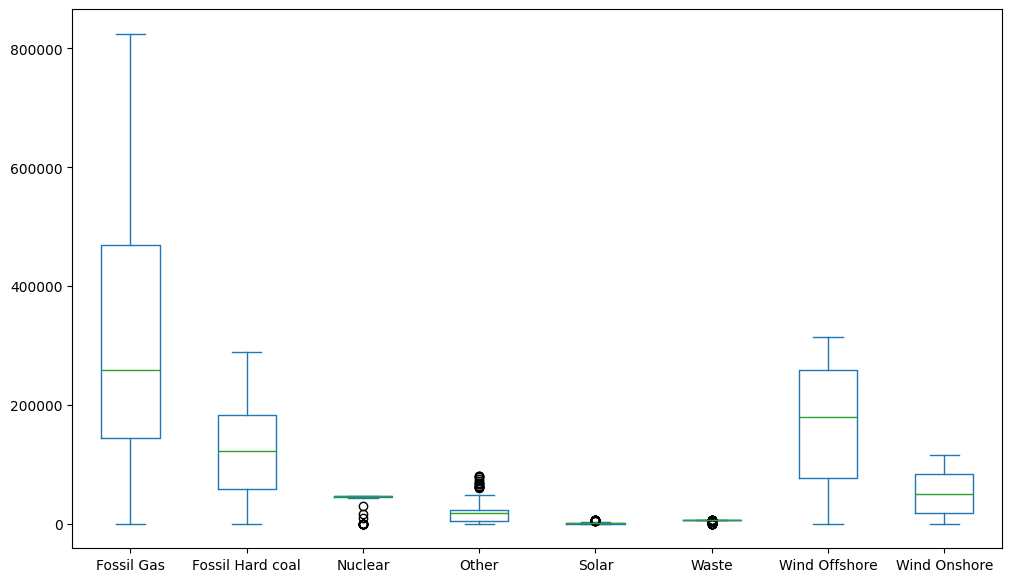

number of outliers in Fossil Gas: 0
number of outliers in Fossil Hard coal: 0
number of outliers in Nuclear: 19
number of outliers in Other: 16
number of outliers in Solar: 15
number of outliers in Waste: 31
number of outliers in Wind Offshore: 0
number of outliers in Wind Onshore: 0


In [49]:
#Remove all columns where all columns are missing or equal to zero
test_data_daily = test_data_daily.loc[:,(test_data**2).sum()!=0]

#Checking the presence of outliers in the dataset
fig = test_data_daily.plot(kind='box',figsize=(12,7))
plt.show()

#Function for getting outlier values
def outlier_detection(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    IQR = q3-q1
    outliers = data[(data < (q1 - 1.5*IQR)) | (data > (q3 + 1.5*IQR))]
    return(outliers)

#Number of outlier points in each column
outlier_data = []
for columns in test_data_daily.columns:
    outliers = outlier_detection(test_data_daily[columns])
    if len(outliers) > 0:
        outlier_data.append(columns)
    print(f"number of outliers in {columns}: "+ str(len(outliers)))

In [50]:
#Function for capping outliers
def impute_outliers(data):
    q1=data.quantile(0.25)
    q3=data.quantile(0.75)
    IQR = q3-q1
    upper = data[~(data>(q3+1.5*IQR))].max()
    lower = data[~(data<(q1-1.5*IQR))].min()
    data = np.where(data > upper,upper,np.where(data < lower,lower,data))
    return data

#Imputing the outliers with capped values
for column in outlier_data:
    test_data_daily.loc[:,column] = impute_outliers(test_data_daily[column])

#Rechecking the values for outliers
for columns in test_data_daily.columns:
    outliers = outlier_detection(test_data_daily[columns])
    if len(outliers) > 0:
        outlier_data.append(columns)
    print(f"number of outliers in {columns}: "+ str(len(outliers)))

number of outliers in Fossil Gas: 0
number of outliers in Fossil Hard coal: 0
number of outliers in Nuclear: 0
number of outliers in Other: 0
number of outliers in Solar: 0
number of outliers in Waste: 0
number of outliers in Wind Offshore: 0
number of outliers in Wind Onshore: 0


SCALING VALUES

The scaling is fit first on the training data and then transformed on it. The test data is transformed using the fit on the training data. In this way scaling is done on the same way as training data.

In [51]:
scaler = MinMaxScaler(feature_range=(0,1))
data_train_scaled = scaler.fit_transform(train_data_daily)
data_test_scaled = scaler.transform(test_data_daily)

Both the training and test data are concatenated to create the time lagged features for prediction. Since we need the first prediction from 2023-09-01, creating the time lagged features for all the feature and late is trimmed so that first prediction will be on 2023-09-01.

In [52]:
#Creating time lagged features for test set
data_test_prediction = np.concatenate((data_train_scaled, data_test_scaled))

print(data_test_prediction.shape)

(572, 8)


<h4> B2 , B3 <h4>

CREATING TIME LAGGED VALUES

To select the number of time lags, we analyse the cross auto correlation between the features in the dataset, based on the peaks above the significance level for target variable with other variable, we can decide on a time lagged window.

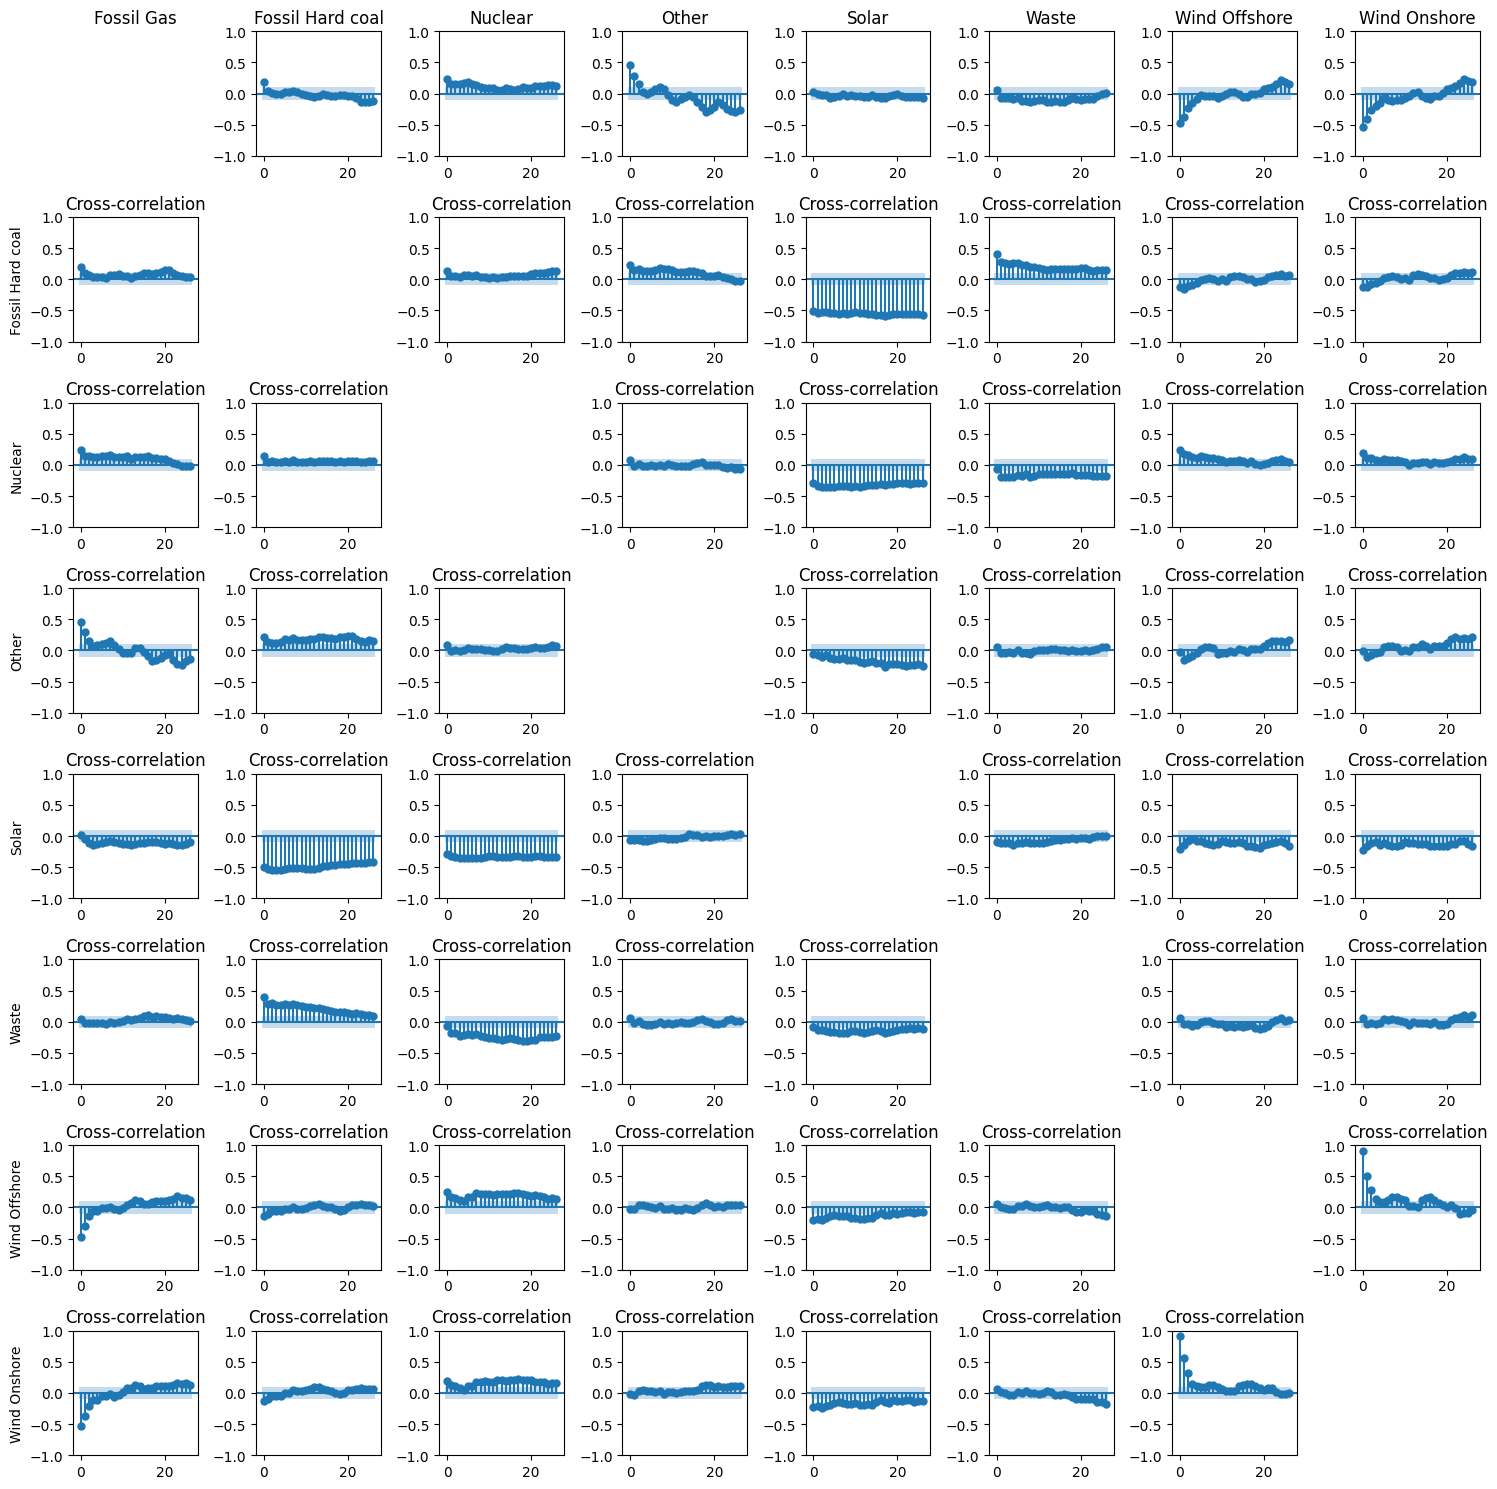

In [53]:
# Get list of column names
column_names = train_data_daily.columns

# Plot CCF for each pair of columns
num_columns = len(column_names)
fig, axes = plt.subplots(num_columns, num_columns, figsize=(15, 15))

for i, col1 in enumerate(column_names):
    for j, col2 in enumerate(column_names):
        ax = axes[i, j]
        if i != j:
            plot_ccf(train_data_daily[col1], train_data_daily[col2], ax=ax)
        else:
            ax.set_axis_off()
        if i == 0:
            ax.set_title(col2)
        if j == 0:
            ax.set_ylabel(col1)

plt.tight_layout()
plt.show()

Time lagged features are created so that for prediction in every point in time, we use data from previous day to predict the next day. Here the time lagged features are created by taking the before day value as X features and predicting for the Wind Onshore on the next day. Based on the autocorrelation plot it can be seen that the 1st lag value has more correlation with the target variable for most of the features and they lie within the significant level. Hence the time lagged features is created for the window of 1 for better prediction.

In [54]:
#Function to create time lagged features
def timelagged(rawdata,n_past):
    data_X = []
    data_Y = []
    for i in range(n_past, len(rawdata)):
            data_X.append(rawdata[i - n_past:i, 0:rawdata.shape[1]])
            data_Y.append(rawdata[i,0:rawdata.shape[1]])
    return np.array(data_X),np.array(data_Y)

#Creating time lagged features for train set
X_train , Y_train = timelagged(data_train_scaled,1)

X_test , Y_test = timelagged(data_test_prediction,1)

X_test , Y_test = X_test[392:] , Y_test[392:]

In [55]:
X_test.shape

(179, 1, 8)

Since the X_test and Y_test contains all the variable, the data is trimmed based on the lagged features to ensure that first Y_test contains 2023-09-01. The lagged features will have past data from the previous day in august for the first prediction. This is done to get a complete prediction from September 2023 - Feb 2024.

<h4> B3 <h4>

![Experimental setup.png](<attachment:Experimental setup.png>)
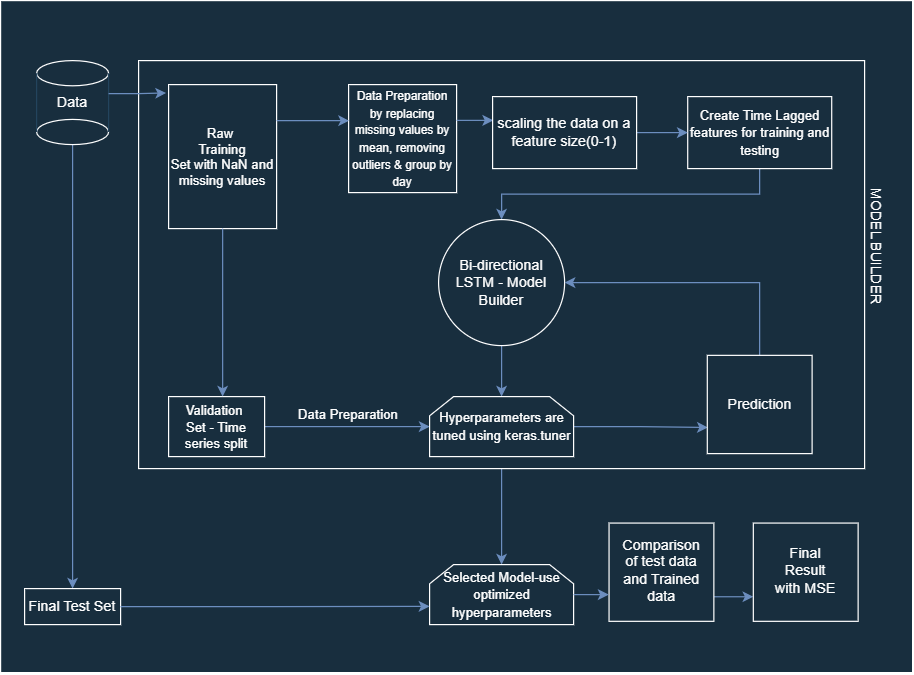

CREATING TIME SERIES SPLIT FOR CROSS VALIDATION

A 4 fold time series split is created where folds are created in a sequential way and hyper parameter tuning is performed based on it to get the best parameters. The experimentation is carried only with the training data. At every fold training data is split into trianing and validation. The Experimental setup is putforward as below

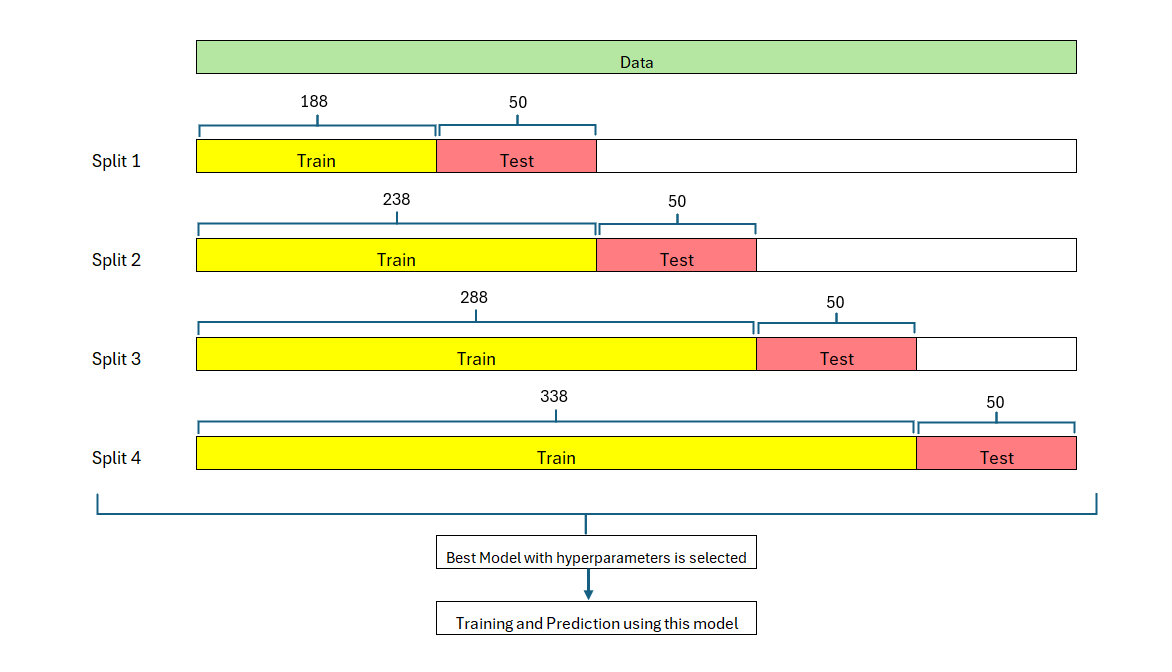

In [56]:
cross_validation = TimeSeriesSplit(n_splits=4 , test_size = 50)
val_loss = []
best_hyperparameters = []
fold_considered = []
history_per_fold = []

<h4> B4 <h4>

MODEL BUILDING

A LSTM model is defined for the time series forecasting. The architecture makes use of a Bidirectional stacked LSTM and hyperparameters are decided from the cross validation. The Bidirectional LSTM has the ability to process input sequences in both forward and backward directions, allowing them to capture both past and future context for making predictions. This feature can help the model to learn dependencies on temporal data.

In [67]:
def lstm(parameters):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=parameters.Int('units1', min_value=100, max_value=250, step=32), return_sequences=True), input_shape=X_train.shape[1:3]))
    model.add(Dense(10, activation=parameters.Choice('dense_activation', values=['relu', 'tanh'])))
    model.add(Bidirectional(LSTM(units=parameters.Int('units2', min_value=32, max_value=128, step=32))))
    model.add(Dense(10, activation=parameters.Choice('dense_activation', values=['relu', 'tanh'])))
    model.add(Dense(10, activation=parameters.Choice('dense_activation', values=['relu', 'tanh'])))
    model.add(Dropout(rate=parameters.Float('dropout', min_value=0.1, max_value=0.3, step=0.05)))
    model.add(Dense(units=8))
    model.compile(loss="mean_squared_error", optimizer=parameters.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),metrics =['mae','mse'])
    return model

<h4> B4 <h4>

Keras tuner is used for hyperparameter tuning and and number of trials is limited to 16 due to restriction of computational resource. Number of epochs is limited to 60 for the same reasons. The hyperparameter selected for tuning are dropout, neuron units for LSTM, activation function and optimizer. These are parameters tuned so as to get a robust regularized model using dropout and correct number of neurons for LSTM to avoid overfitting because too many neurons in a single layer. The activation function influences the output from each neuron and the type of activation influences the output of the model. Hence these values are used for hyperparameter tuning.

In [68]:
tuner= kt.RandomSearch(lstm,objective='mse',max_trials=20,executions_per_trial=3)

Reloading Tuner from .\untitled_project\tuner0.json


In [69]:
for train_index , val_index in cross_validation.split(X_train):

    X_train1, X_val = X_train[train_index], X_train[val_index]
    y_train1, y_val = Y_train[train_index], Y_train[val_index]
    tuner.search(x=X_train1,y=y_train1,epochs=60,batch_size=16,validation_data=(X_val, y_val))

    best_trial = tuner.oracle.get_best_trials(1)[0]
    best_hp = best_trial.hyperparameters
    
    best_hyperparameters.append(best_hp)
    fold_considered.append(X_train1.shape)

    fold_model = tuner.hypermodel.build(best_hp)

    # Train the model and save the training history
    history = fold_model.fit(X_train1, y_train1, epochs=60, batch_size=16, validation_data=(X_val, y_val), verbose=0)
    history_per_fold.append(history.history)
    
    val_loss_fold = fold_model.evaluate(X_val, y_val, verbose=0)
    val_loss.append(val_loss_fold)

After the entire trail is ran, the best hyperparameter is selected from the loss function.

The graphs are plotted for the best model from each fold.

The MSE loss is plotted for best model on every fold.

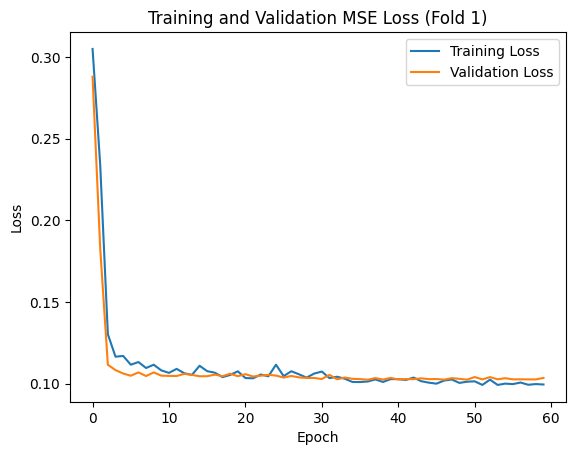

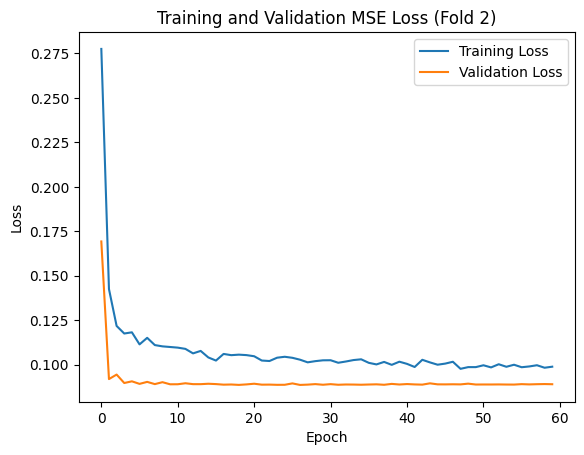

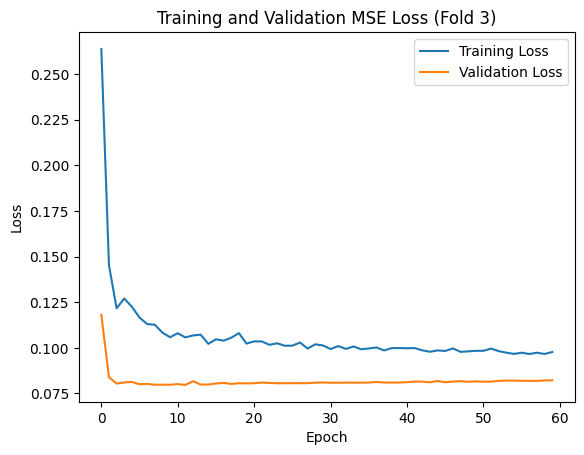

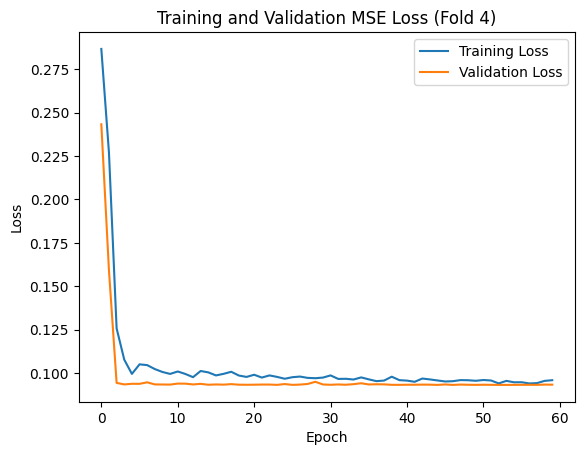

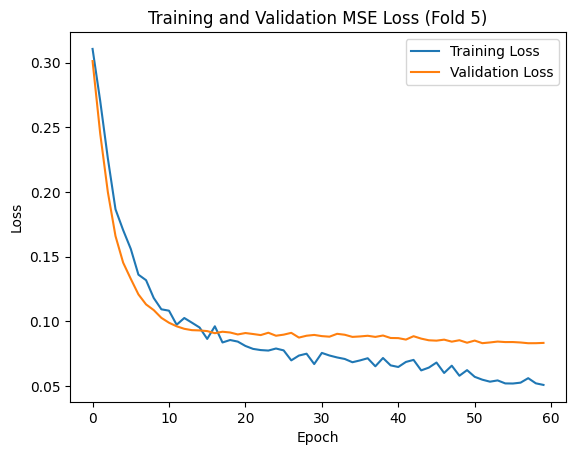

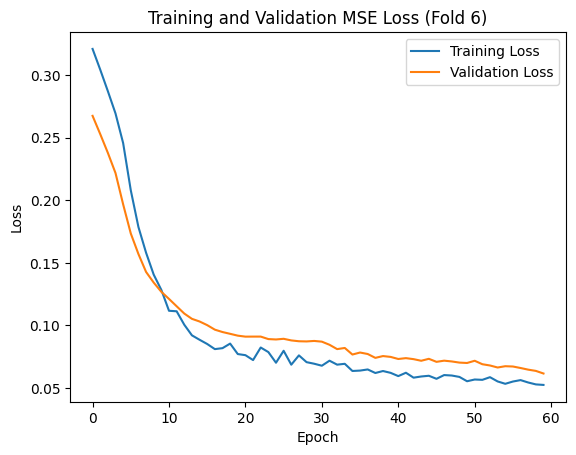

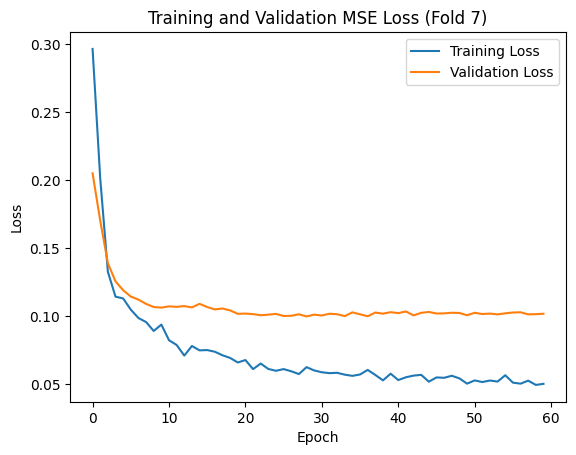

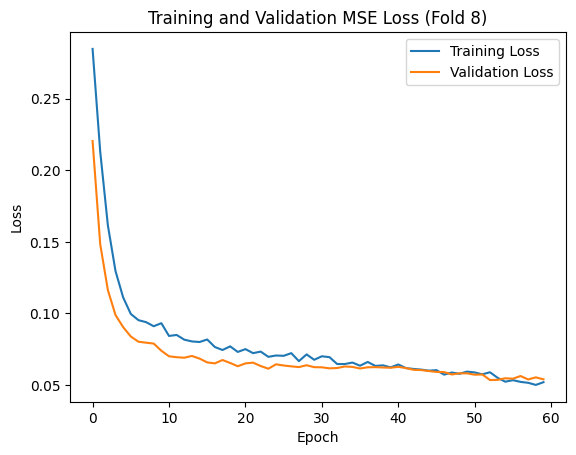

In [70]:
for fold, history in enumerate(history_per_fold):
    plt.figure()
    plt.plot(history['mse'], label='Training Loss')
    plt.plot(history['val_mse'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation MSE Loss (Fold {fold+1})')
    plt.legend()

# Show all plots
plt.show()

The MAE loss is plotted for best model in every fold

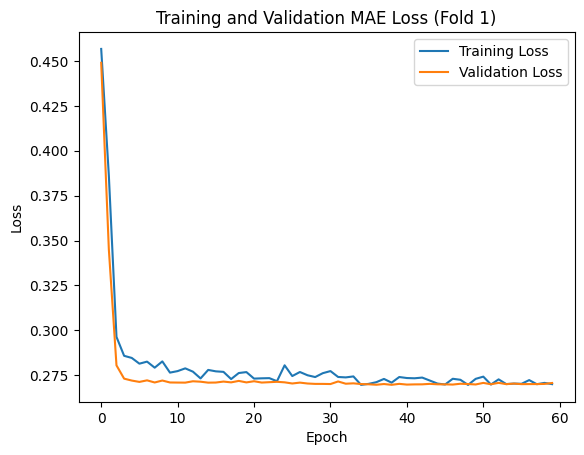

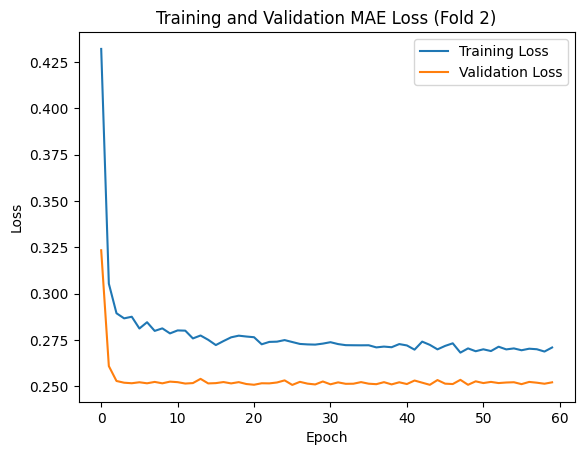

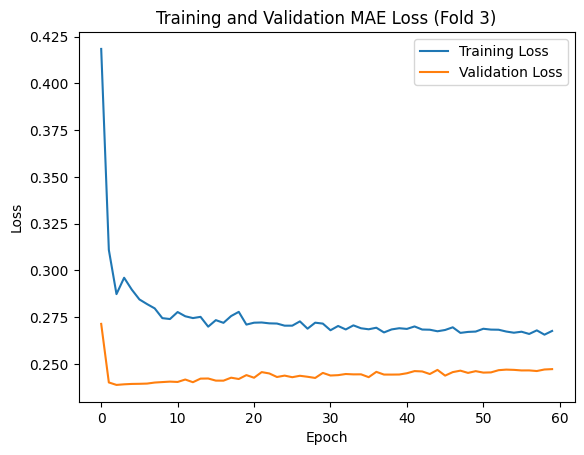

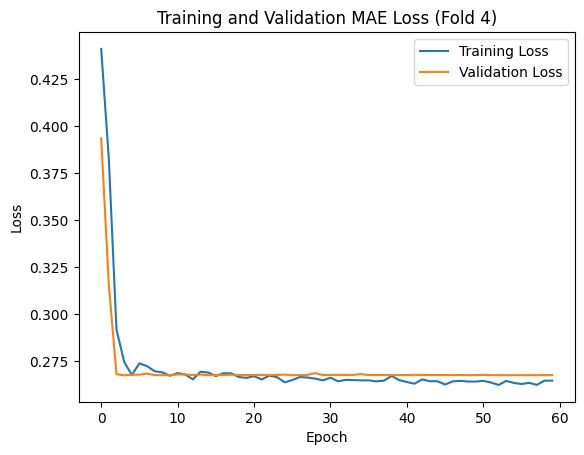

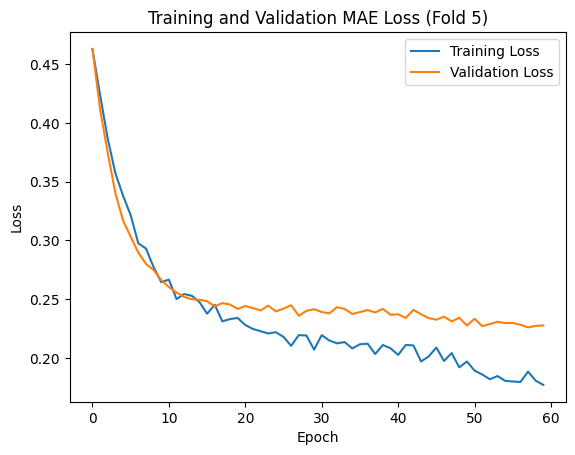

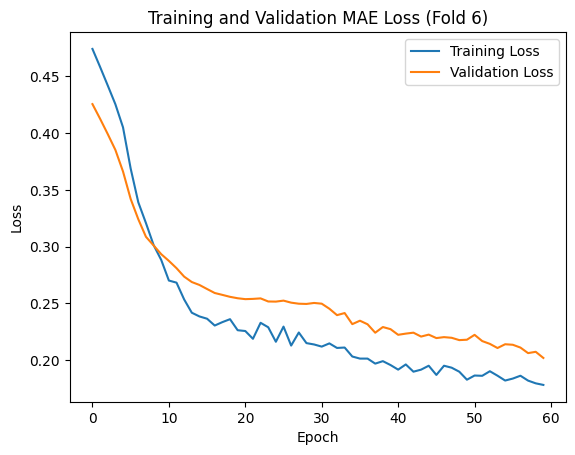

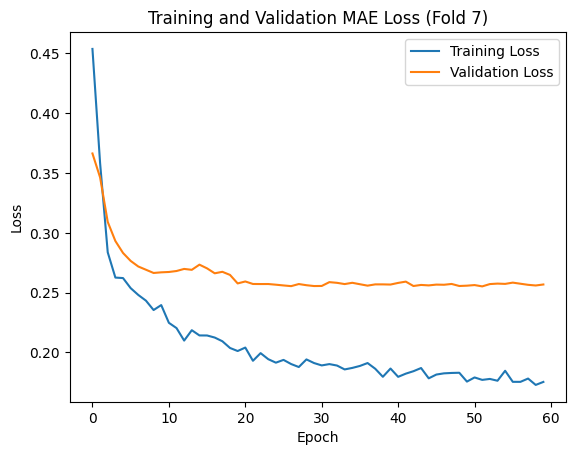

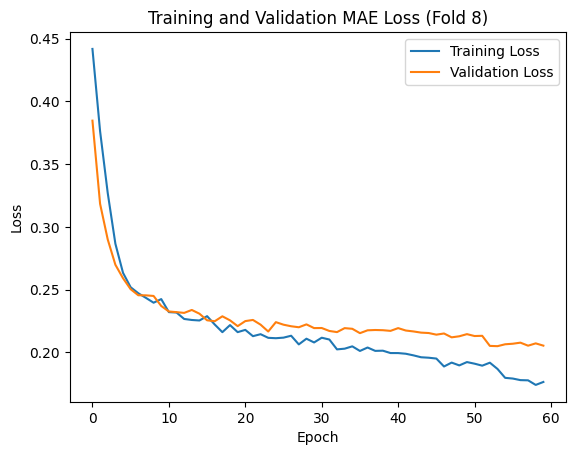

In [71]:
for fold, history in enumerate(history_per_fold):
    plt.figure()
    plt.plot(history['mae'], label='Training Loss')
    plt.plot(history['val_mae'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation MAE Loss (Fold {fold+1})')
    plt.legend()

# Show all plots
plt.show()

The best hyperparameters are taken after the whole validation is done. This is limited based on the number of trails allocated.

In [72]:
best_trial = tuner.oracle.get_best_trials(1)[0]
best_hp = best_trial.hyperparameters
print(best_hp.values)

{'units1': 228, 'dense_activation': 'relu', 'units2': 96, 'dropout': 0.2, 'optimizer': 'adam'}


Best model is built using the hyperparameters

In [73]:
# Build the best model
best_model = tuner.hypermodel.build(best_hp)
best_model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_28                │ (None, 1, 456)         │       432,288 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1, 10)          │         4,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_29                │ (None, 192)            │        82,176 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 10)             │         1,930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 8)              │            88 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 521,162 (1.99 MB)

 Trainable params: 521,162 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

<h4> B5 <h4>

The model is trained using the data allocated for training. The training and validation loss during the training process is plotted. From the model it can be seen that validation loss is consistently less than the training loss. This can be result of overfitting on the training dataset because of more complex model and less datapoints. Since the model is complex, it generalizes well for the validation dataset, hence the validation loss is less consistently less for the training.

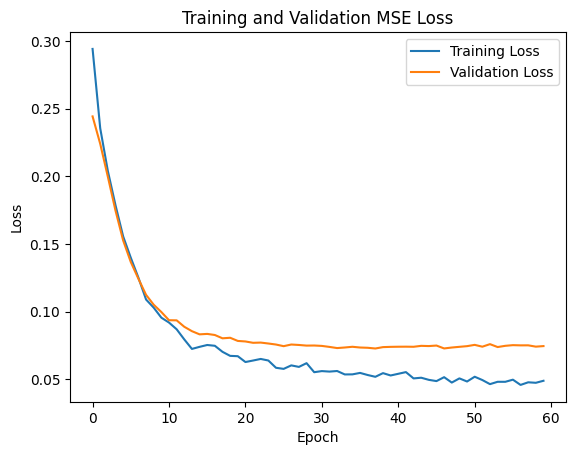

In [74]:
# Train the model and save the training history
history = best_model.fit(X_train, Y_train, epochs=60, batch_size=16, validation_split=0.3, verbose=0)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training and Validation MSE Loss')
plt.legend()

The prediction is done using the trained model and the prediction is done for the whole window from september till february.

In [75]:
#Initialize a list to store predictions
Final_prediction = best_model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step


In [76]:
Final_prediction.shape

(179, 8)

In [77]:
Final_prediction

array([[0.46900573, 0.5197768 , 0.4406913 , ..., 0.7431117 , 0.2946006 ,
        0.21132399],
       [0.54575586, 0.58315074, 0.5875663 , ..., 0.76220727, 0.2922271 ,
        0.19079682],
       [0.48486802, 0.57280296, 0.5378873 , ..., 0.75725156, 0.29658836,
        0.20844597],
       ...,
       [0.1660523 , 0.4409657 , 0.91603774, ..., 0.7521991 , 0.72741604,
        0.7175939 ],
       [0.33149767, 0.53140855, 0.8554958 , ..., 0.76304746, 0.5726831 ,
        0.52397346],
       [0.39647925, 0.5838039 , 0.8136959 , ..., 0.7804855 , 0.48045236,
        0.41613188]], dtype=float32)

The performance measure is calculated for the predicted data and the following measures are calculated.

In [150]:
# Evaluate performance on the test set
test_mean_squared_error = mean_squared_error(Y_test, Final_prediction)
test_mean_absolute_error = mean_absolute_error(Y_test, Final_prediction)
r_squared = r2_score(Y_test, Final_prediction)

print(f"Test MSE: {test_mean_squared_error}")
print(f"Test MAE: {test_mean_absolute_error}")
print(f"R Squared: {r_squared}")

Test MSE: 0.08694091670276985
Test MAE: 0.23669104795956494
R Squared: 0.35081274295510967


A inversion function is built for getting the original values from scaled predictions. The values are scaled separately and compared directly to the actual values. 

In [151]:
#Function for inversion
def Inverse_min_max(scaled_val):
    max_val = max(train_data_daily['Wind Onshore'])
    min_val = min(train_data_daily['Wind Onshore'])
    original_val = (scaled_val*(max_val - min_val)) + min_val
    return original_val

Predictions_scaled = pd.DataFrame(Final_prediction, columns=['Scaled Prediction'])

New_predictions = pd.DataFrame()
New_predictions['Wind Onshore Predictions'] = Predictions_scaled['Scaled Prediction'].apply(lambda x: Inverse_min_max(x))

# Define the start date and number of rows
start_date = '2023-09-01'
num_rows = 179  # Adjust this according to the number of rows you need

# Create a range of dates
date_range = pd.date_range(start=start_date, periods=num_rows, freq='D')

# Create a DataFrame with the Date column
date_df = pd.DataFrame({'DateTime': date_range})

New_predictions = pd.concat([New_predictions, date_df], axis=1)
#Changing the datatype of Datetime in the given data
New_predictions['DateTime'] = pd.to_datetime(New_predictions['DateTime'])
#Setting Datetime as index
New_predictions.set_index('DateTime', inplace=True)

Error_Comparison = New_predictions.join(test_data_daily['Wind Onshore'])
Error_Comparison

,Wind Onshore Predictions,Wind Onshore
DateTime,,
2023-09-01,16940.498444,2888.0
2023-09-02,15592.078822,3478.0
2023-09-03,16232.688981,1891.0
2023-09-04,18963.294135,8867.0
2023-09-05,17985.616017,15935.0
...,...,...
2024-02-22,79439.695355,76078.0
2024-02-23,72077.863063,86579.0
2024-02-24,75748.584923,40481.0


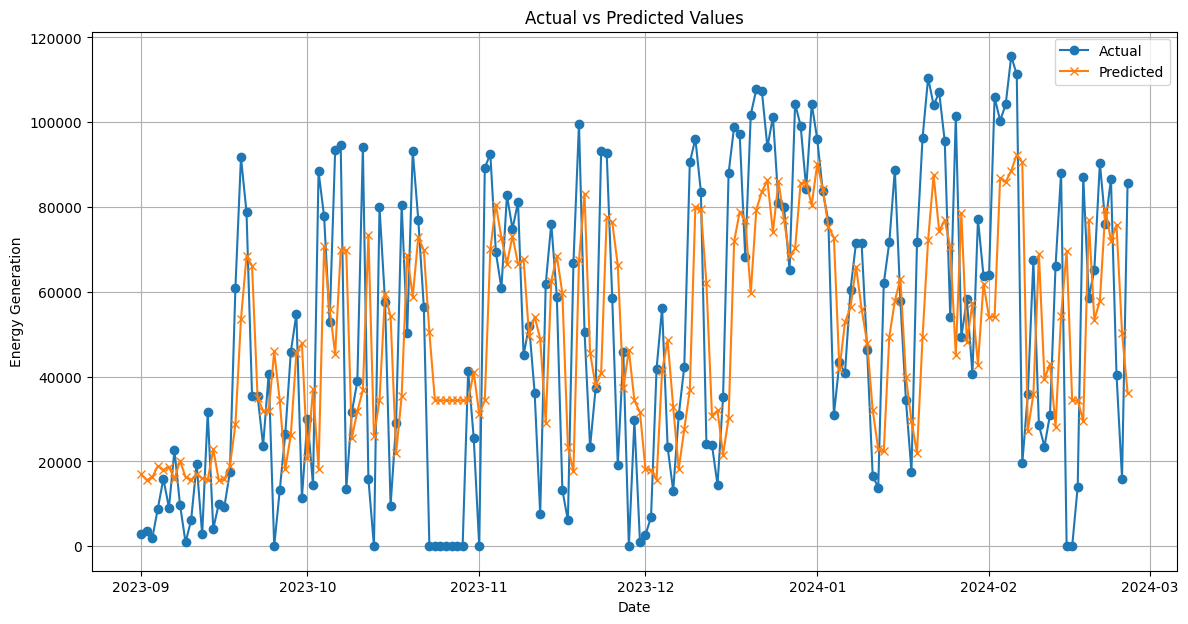

In [152]:
# Create a plot
plt.figure(figsize=(14, 7))
plt.plot(Error_Comparison['Wind Onshore'], label='Actual', marker='o')
plt.plot(Error_Comparison['Wind Onshore Predictions'], label='Predicted', marker='x')
plt.xlabel('Date')
plt.ylabel('Energy Generation')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

B6

From the training results, it can be seen that validation loss is less compared to the training loss by 2%. Since the difference is not significant the validation loss is less due to not tuning the learning parameter. The overfitting can also be due to complexity of the model and less complex training data. Hence the model is overfitting on the training dataset resulting in comparitevly higher error. Since the model is complex, it may generalize well for the validation dataset leading to lower validation errors. From the testing results, the test MSE is reported to 8% on 0 to 1 scale. The MAE value is higher because the loss function selected is MSE and the model is trying to optimize for very large errors leading to higher error in the MAE. R square indicates that 35% of the variation in the testing data can be accounted by the model. A better point to improve is to build a simple baseline model and test on it, to reflect the issues regarding complexity nature of the current model.

<h3> C1 <h3>

In [156]:
Model_A = pd.DataFrame()
Model_A['Wind Onshore Prediction Model A'] = y_test_pred

# Define the start date and number of rows
start_date = '2023-09-01'
num_rows = 179  # Adjust this according to the number of rows you need

# Create a range of dates
date_range = pd.date_range(start=start_date, periods=num_rows, freq='D')

# Create a DataFrame with the Date column
date_df = pd.DataFrame({'DateTime': date_range})

Model_A = pd.concat([Model_A, date_df], axis=1)
#Changing the datatype of Datetime in the given data
Model_A['DateTime'] = pd.to_datetime(Model_A['DateTime'])
#Setting Datetime as index
Model_A.set_index('DateTime', inplace=True)

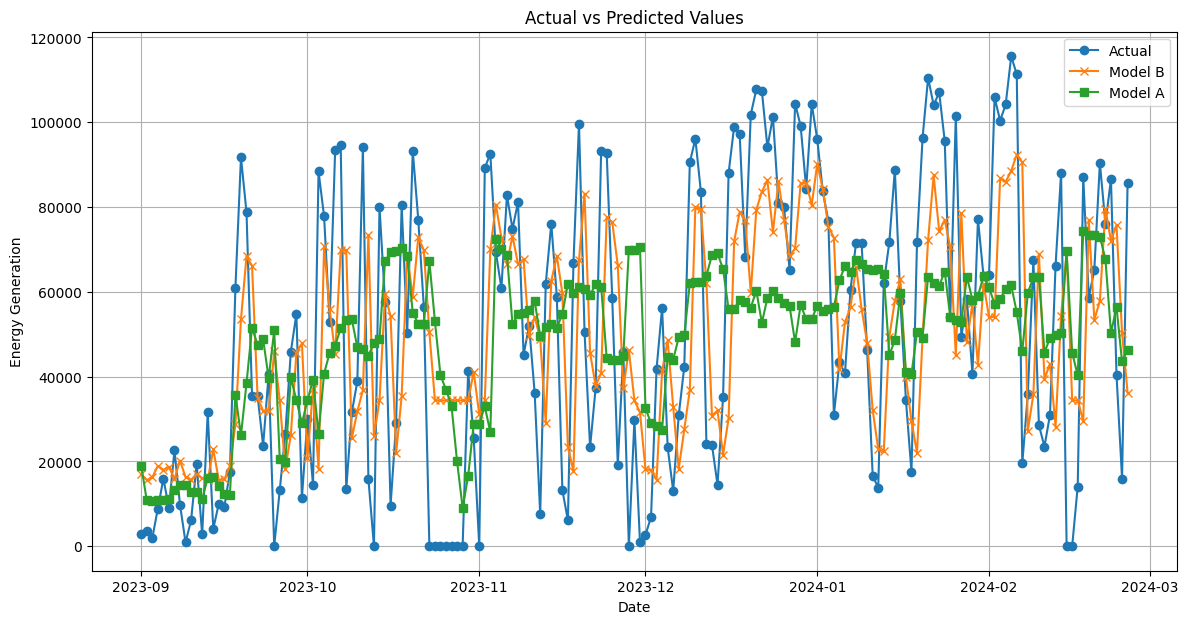

In [159]:
# Create a plot
plt.figure(figsize=(14, 7))
plt.plot(Error_Comparison['Wind Onshore'], label='Actual', marker='o')
plt.plot(Error_Comparison['Wind Onshore Predictions'], label='Model B', marker='x')
plt.plot(Model_A['Wind Onshore Prediction Model A'], label='Model A', marker='s')
plt.xlabel('Date')
plt.ylabel('Energy Generation')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

Conclusion :
From the model results, it can be seen that Model B has good prediction capabilities for most of the test points. Looking at it from the performance metrics MSE, MAE and R Squared values are comparatively better for Model B than Model A. This can be due to the complexity of the model B.

Recommendation :
If the government wants a model that is based on accuracy it is better to use the Model B. But if the interpretabiity of the model matters matters, the random forest will have better insight into it.

![Final results.png](<attachment:Final results.png>)
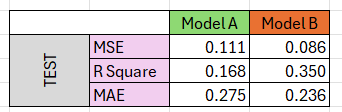